In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
warnings.filterwarnings("ignore")
from IPython.display import display


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [14]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        if uniqueEntities[i]["SHARPE"] > 1.0:
            uniqueModelsToKeep.append(uniqueModels[i])
        else:
            continue
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [15]:
uniqueModels = getAllUniqueModels()

***ORIGINAL MODELS***
((10, ('FXE', 2, None, None), 5, 'VTI'), 10, 250)
((10, ('IEF', 3, None, None), 3, 'EWT'), 10, 250)
((22, ('QQQ', 10, None, None), 2, 'EEM'), 22, 25)
((10, ('IJR', 34, None, 6), 3, 'ITB'), 10, 50)
((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IVV', 4, 19, 9), 3, 'EWU'), 22, 50)
((10, ('EWT', 33, None, None), 3, 'XLY'), 10, 50)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('EWT', 33, None, None), 5, 'XLY'), 10, 100)
((10, ('IEF', 25, None, None), 5, 'VTI'), 10, 25)
((22, ('DXJ', 18, 16, 21), 5, 'VUG'), 22, 250)
((22, ('IEF', 27, None, 9), 3, 'IVW'), 22, 25)
((22, ('FXE', 29, 18, 19), 5, 'XLI'), 22, 25)
((10, ('EWH', 5, None, 10), 3, 'EWT'), 10, 100)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((22, ('VIG', 6, None, 12), 3, 'IJH'), 22, 25)
((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 50)
((10, ('VGK', 38, None, 16), 3, 'XLB'), 10, 100)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((22, ('XLV', 26, None, None), 5, 'OEF'), 22, 25)
((10, ('T

In [4]:
# uniqueModels = getUniqueModelsForTicker("EWZ") + getUniqueModelsForTicker("OEF")

***ORIGINAL MODELS***
((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 50)
((22, ('GDX', 32, None, None), 5, 'EWZ'), 22, 50)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 25)
((22, ('GDX', 32, None, None), 2, 'EWZ'), 22, 250)
((10, ('GDX', 32, None, None), 5, 'EWZ'), 10, 25)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((10, ('GDX', 32, None, None), 2, 'EWZ'), 10, 100)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 250)
((10, ('GDX', 32, None, None), 3, 'EWZ'), 10, 50)
***UNIQUE MODELS***
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
25TH PERCENTILE SHARPE 1.0421233172372808
ACTIVITY 0.8867719107240065
ALPHA 0.31536348810292847
ANNUALIZED RETURN 0.35303400909922455
BETA 0.2512840443703012
MIN ROLLING SHARPE -0.06045637955271487
OOS_ACTIVITY 0.8571428571428571
OOS_ALPHA 0.2208964646675671
OOS_ANNUALIZED RETURN 0.2183005334647803
OOS_BETA 0.017703288037019396
OOS_RAW BETA 0.05148741418764301
OOS_SHARPE 1.0940734507376269
OOS_STABILITY 0.19187004910345523
OOS_TREYNOR 3.305818781360

In [16]:
def computeReturnsForUniqueModels(uniqueModels, factorToTrade):
    tickersRequired = []
    tickersTraded = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
        if mod.inputSeries.series.ticker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.series.ticker)
        if mod.inputSeries.targetTicker not in tickersTraded:
            tickersTraded.append(mod.inputSeries.targetTicker)

    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions = portfolioGeneration.generateAllReturns(uniqueModels, joinedData)
    
    return modelReturns, modelPredictions, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [17]:
factorToTrade = "SPY"
modelReturns, modelPredictions, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModels(uniqueModels, factorToTrade)

((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)
((10, ('SLV', 10, None, None), 5, 'XLB'), 10, 250)
((10, ('TLT', 8, None, 21), 2, 'VTI'), 10, 50)
((10, ('DXJ', 18, 16, 21), 5, 'VUG'), 10, 100)
GDX
VO
SHY
IEF
OEF
EWZ
EWH
XLV
EWT
SLV
XLB
DXJ
VTI
TLT
VUG
SPY
((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
THREAD  0 PROGRESS: 0.5660377358490566
THREAD  3 PROGRESS: 0.5660377358490566
THREAD  2 PROGRESS: 0.5660377358490566
THREAD  1 PROGRESS: 0.5660377358490566
THREAD  4 PROGRESS: 0.5660377358490566
THREAD  9 PROGRESS: 0.5769230769230769
THREAD  6 PROGRESS: 0.5660377358490566
THREAD  5 PROGRESS: 0.5660377358490566
THREAD  7 PROGRESS: 0.5660377358490566
THREAD  13 PROGRESS: 0.5769230769230769
THREAD  10 PROGRESS: 0.5769230769230769
THREAD  8 PROGRESS: 0.5660377358490566
THREAD  12 PROGRESS: 0.5769

In [18]:
##600 DAY DELAY BECAUSE OF MINIMUM PREDICTION REQUIREMENT
display(modelPredictions)

,"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)","((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)","((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)","((10, ('SLV', 10, None, None), 5, 'XLB'), 10, 250)","((10, ('TLT', 8, None, 21), 2, 'VTI'), 10, 50)","((10, ('DXJ', 18, 16, 21), 5, 'VUG'), 10, 100)"
2005-03-09,-0.5,NaN,0.0,NaN,0.5,NaN,NaN,NaN
2005-03-10,-1.0,NaN,0.0,NaN,0.5,NaN,NaN,NaN
2005-03-11,0.0,NaN,1.0,NaN,0.5,NaN,NaN,NaN
2005-03-14,1.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN
2005-03-15,0.5,NaN,0.0,NaN,1.0,NaN,NaN,NaN
2005-03-16,0.5,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2005-03-17,0.0,NaN,1.0,NaN,0.5,NaN,NaN,NaN
2005-03-18,0.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN
2005-03-21,1.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
2005-03-22,0.0,NaN,-1.0,NaN,0.0,NaN,NaN,NaN


,"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)","((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)","((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)","((10, ('SLV', 10, None, None), 5, 'XLB'), 10, 250)","((10, ('TLT', 8, None, 21), 2, 'VTI'), 10, 50)","((10, ('DXJ', 18, 16, 21), 5, 'VUG'), 10, 100)",Factor Return
"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)",1.000000,0.011930,0.026737,-0.000014,-0.053532,-0.029707,-0.014301,-0.039851,-0.038466
"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)",0.011930,1.000000,-0.059745,0.111358,-0.025923,0.096920,0.096193,0.168467,0.401009
"((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)",0.026737,-0.059745,1.000000,0.035915,-0.011538,-0.070739,-0.000254,-0.068325,-0.052492
"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)",-0.000014,0.111358,0.035915,1.000000,0.080394,0.123121,0.052891,0.102376,0.302434
"((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)",-0.053532,-0.025923,-0.011538,0.080394,1.000000,0.119268,-0.117375,0.161551,0.142921
"((10, ('SLV', 10, None, None), 5, 'XLB'), 10, 250)",-0.029707,0.096920,-0.070739,0.123121,0.119268,1.000000,0.093378,0.265858,0.362744
"((10, ('TLT', 8, None, 21), 2, 'VTI'), 10, 50)",-0.014301,0.096193,-0.000254,0.052891,-0.117375,0.093378,1.000000,0.004325,0.247003
"((10, ('DXJ', 18, 16, 21), 5, 'VUG'), 10, 100)",-0.039851,0.168467,-0.068325,0.102376,0.161551,0.265858,0.004325,1.000000,0.316319
Factor Return,-0.038466,0.401009,-0.052492,0.302434,0.142921,0.362744,0.247003,0.316319,1.000000


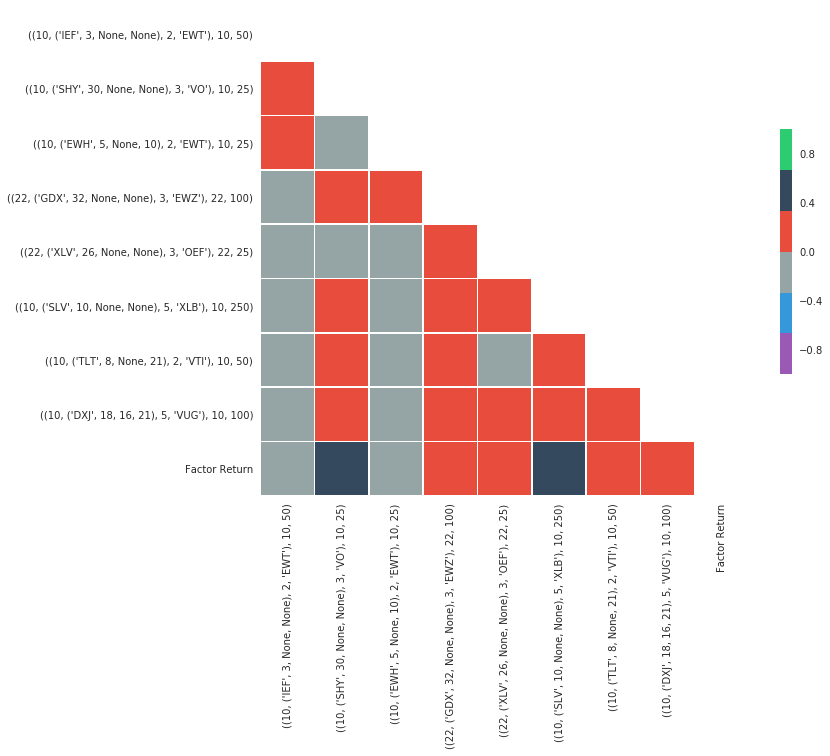

,"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)","((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)","((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)","((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)","((10, ('SLV', 10, None, None), 5, 'XLB'), 10, 250)","((10, ('TLT', 8, None, 21), 2, 'VTI'), 10, 50)","((10, ('DXJ', 18, 16, 21), 5, 'VUG'), 10, 100)",Factor Return
"((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)",7.232980e-05,7.211514e-07,2.204056e-06,-1.706207e-09,-2.569578e-06,-0.000002,-9.686164e-07,-2.106735e-06,-0.000003
"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)",7.211514e-07,5.052154e-05,-4.116221e-06,1.174888e-05,-1.039968e-06,0.000005,5.444988e-06,7.443346e-06,0.000027
"((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)",2.204056e-06,-4.116221e-06,9.395319e-05,5.167365e-06,-6.311956e-07,-0.000005,-1.961519e-08,-4.116728e-06,-0.000005
"((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)",-1.706207e-09,1.174888e-05,5.167365e-06,2.203311e-04,6.735180e-06,0.000015,6.252214e-06,9.446066e-06,0.000043
"((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)",-2.569578e-06,-1.039968e-06,-6.311956e-07,6.735180e-06,3.185500e-05,0.000005,-5.275690e-06,5.667792e-06,0.000008
"((10, ('SLV', 10, None, None), 5, 'XLB'), 10, 250)",-2.012623e-06,5.487777e-06,-5.462108e-06,1.455847e-05,5.362423e-06,0.000063,5.923865e-06,1.316471e-05,0.000028
"((10, ('TLT', 8, None, 21), 2, 'VTI'), 10, 50)",-9.686164e-07,5.444988e-06,-1.961519e-08,6.252214e-06,-5.275690e-06,0.000006,6.342083e-05,2.140759e-07,0.000019
"((10, ('DXJ', 18, 16, 21), 5, 'VUG'), 10, 100)",-2.106735e-06,7.443346e-06,-4.116728e-06,9.446066e-06,5.667792e-06,0.000013,2.140759e-07,3.863946e-05,0.000019
Factor Return,-3.138635e-06,2.734626e-05,-4.881487e-06,4.306989e-05,7.739078e-06,0.000028,1.887226e-05,1.886455e-05,0.000092


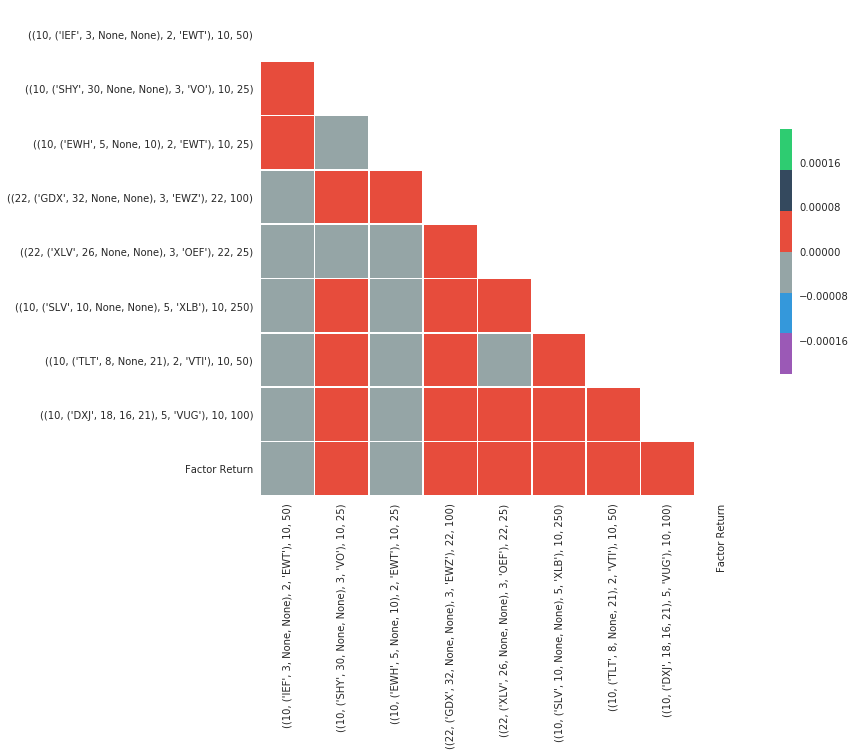

In [19]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [20]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

((10, ('IEF', 3, None, None), 2, 'EWT'), 10, 50)
((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((10, ('EWH', 5, None, 10), 2, 'EWT'), 10, 25)
((22, ('GDX', 32, None, None), 3, 'EWZ'), 22, 100)
((22, ('XLV', 26, None, None), 3, 'OEF'), 22, 25)
((10, ('SLV', 10, None, None), 5, 'XLB'), 10, 250)
((10, ('TLT', 8, None, 21), 2, 'VTI'), 10, 50)
((10, ('DXJ', 18, 16, 21), 5, 'VUG'), 10, 100)


In [21]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="Small Test Over Sharpe 1 vs SPY", benchmark=factorToTrade)

PORTFOLIO HASH: aabed521218c07703b239987504cab23361f2a3bb3619de60e608399
0b84734d97e005d3a2a3a06d82cb793ec1f7557573e3bc032fb7fdf3
4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212
83042ffdb976d2bd4f952da1cac1d5bfc80aac99497b9c9821b4e3fb
89a1acee0dad3f2ab28abba71b79d42433b5963a2403743445ea0013
a1f87383e9c791f7fbf2d8c52efe4e378bcae15f9773f23377e607a9
a762825ed2a3e080b702b24d23121d77b9e6b6fe24af40f5d3187f44
b903708f9b21d044698db01d68f6be915739a688f28c591eb57807c3
bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e


In [22]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['b903708f9b21d044698db01d68f6be915739a688f28c591eb57807c3',
 '83042ffdb976d2bd4f952da1cac1d5bfc80aac99497b9c9821b4e3fb',
 '0b84734d97e005d3a2a3a06d82cb793ec1f7557573e3bc032fb7fdf3',
 '4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212',
 'a762825ed2a3e080b702b24d23121d77b9e6b6fe24af40f5d3187f44',
 'bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e',
 '89a1acee0dad3f2ab28abba71b79d42433b5963a2403743445ea0013',
 'a1f87383e9c791f7fbf2d8c52efe4e378bcae15f9773f23377e607a9']

In [23]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [24]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,b903708f9b21d044698db01d68f6be915739a688f28c591eb57807c3,4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212,a762825ed2a3e080b702b24d23121d77b9e6b6fe24af40f5d3187f44,a1f87383e9c791f7fbf2d8c52efe4e378bcae15f9773f23377e607a9,83042ffdb976d2bd4f952da1cac1d5bfc80aac99497b9c9821b4e3fb,89a1acee0dad3f2ab28abba71b79d42433b5963a2403743445ea0013,0b84734d97e005d3a2a3a06d82cb793ec1f7557573e3bc032fb7fdf3,bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e
2005-03-24,0.000000,NaN,-0.002240,NaN,NaN,NaN,NaN,NaN
2005-03-28,-0.027871,NaN,0.027871,NaN,NaN,NaN,NaN,NaN
2005-03-29,0.006307,NaN,-0.012615,NaN,NaN,NaN,NaN,NaN
2005-03-30,-0.007928,NaN,-0.015855,NaN,NaN,NaN,NaN,NaN
2005-03-31,-0.006689,NaN,-0.006689,NaN,NaN,NaN,NaN,NaN
2005-04-01,0.013289,NaN,0.013289,NaN,NaN,NaN,NaN,NaN
2005-04-04,-0.002245,NaN,-0.002245,NaN,NaN,NaN,NaN,NaN
2005-04-05,0.000000,NaN,-0.007839,NaN,NaN,NaN,NaN,NaN
2005-04-06,-0.000000,NaN,-0.000000,NaN,NaN,NaN,NaN,NaN
2005-04-07,0.000000,NaN,0.002245,NaN,NaN,NaN,NaN,NaN


In [33]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,b903708f9b21d044698db01d68f6be915739a688f28c591eb57807c3,4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212,a762825ed2a3e080b702b24d23121d77b9e6b6fe24af40f5d3187f44,a1f87383e9c791f7fbf2d8c52efe4e378bcae15f9773f23377e607a9,83042ffdb976d2bd4f952da1cac1d5bfc80aac99497b9c9821b4e3fb,89a1acee0dad3f2ab28abba71b79d42433b5963a2403743445ea0013,0b84734d97e005d3a2a3a06d82cb793ec1f7557573e3bc032fb7fdf3,bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e
2009-05-11,0.014039,-0.000792,-0.000000,-0.002623,-0.006296,0.000060,-0.008357,-0.009198
2009-05-12,0.023001,0.009887,0.023001,-0.028490,0.021644,0.002774,-0.020311,-0.025907
2009-05-13,-0.007848,0.000000,0.000000,0.010151,-0.004771,-0.001144,0.000000,0.011836
2009-05-14,-0.003337,-0.003744,0.000000,-0.000000,-0.001992,0.001364,-0.000000,-0.009717
2009-05-15,-0.047672,0.026408,0.000000,-0.030693,-0.012544,-0.011404,0.000000,0.016244
2009-05-18,-0.008466,-0.001838,0.000000,-0.000219,-0.005789,-0.000401,0.000000,0.008834
2009-05-19,0.003673,-0.006575,-0.000000,-0.000000,-0.002331,0.000816,-0.002804,0.005937
2009-05-20,-0.002114,-0.006619,-0.004228,-0.018054,0.011181,0.013317,-0.011169,-0.008316
2009-05-21,0.000000,-0.000000,0.000000,0.000673,0.002428,0.001057,-0.001442,0.002643
2009-05-22,-0.000000,-0.011443,0.002081,0.026888,-0.018198,-0.024254,0.034038,0.007090


,b903708f9b21d044698db01d68f6be915739a688f28c591eb57807c3,4018e7b6f84216af0c0b942847d8ee439f42a184fcc9a0ccea90f212,a762825ed2a3e080b702b24d23121d77b9e6b6fe24af40f5d3187f44,a1f87383e9c791f7fbf2d8c52efe4e378bcae15f9773f23377e607a9,83042ffdb976d2bd4f952da1cac1d5bfc80aac99497b9c9821b4e3fb,89a1acee0dad3f2ab28abba71b79d42433b5963a2403743445ea0013,0b84734d97e005d3a2a3a06d82cb793ec1f7557573e3bc032fb7fdf3,bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e
2009-05-11,-1.0,-1.0,0.0,1.0,-0.6250,-0.0625,1.0,0.75
2009-05-12,-1.0,-0.5,-1.0,1.0,-0.5000,-0.1250,0.5,0.50
2009-05-13,-1.0,0.0,0.0,1.0,-0.5625,-0.1875,0.0,0.50
2009-05-14,-1.0,0.5,0.0,0.0,-0.5625,-0.3125,0.0,0.50
2009-05-15,-1.0,1.0,0.0,-1.0,-0.4375,-0.4375,0.0,0.25
2009-05-18,-1.0,1.0,0.0,-1.0,-0.5000,-0.5625,0.0,0.75
2009-05-19,-0.5,1.0,0.0,0.0,-0.5000,-0.6875,0.5,0.75
2009-05-20,0.5,0.5,1.0,1.0,-0.5000,-0.8125,0.5,0.50
2009-05-21,0.0,0.0,0.0,1.0,-0.6250,-0.8750,0.5,0.25
2009-05-22,0.0,-0.5,-1.0,1.0,-0.7500,-0.9375,1.0,0.25


In [ ]:

hrpReturns, historicalWeights = portfolioGeneration.\
    produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
    100, startIndex=None, maxWindowSize=True)
print("COMPUTED HISTORICAL WEIGHTS")
display(historicalWeights)
portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                allModels, historicalWeights, cleanedAggregatePredictions)

In [ ]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData)
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData)